In [ ]:
# Importing necessary libraries

import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
import random
import shutil


In [ ]:
#Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to the data directory

data_dir = '/content/drive/MyDrive/DS/Final_Dataset_A_Z_SK_NewSign'
test_dir = '/content/drive/MyDrive/DS/Test_NEW_SK_A_Z_1_9'
IMAGE_SIZE=32
BATCH_SIZE=32

# Calculate the split sizes
train_split = 0.7
val_split = 0.3
test_split = 0.1

# Get the total number of images
total_images = sum([len(files) for r, d, files in os.walk(data_dir)])

# Calculate the number of images for each split
train_size = int(total_images * train_split)
val_size = int(total_images * val_split)
test_size = int(total_images * test_split)

# Calculate the steps per epoch for training and validation
train_steps_per_epoch = train_size // BATCH_SIZE
val_steps_per_epoch = val_size // BATCH_SIZE
test_steps_per_epoch = test_size // BATCH_SIZE

In [ ]:
# Data generator for training set for VGG-16 Model

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    # channel_shift_range=5,  # Color Jittering
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape),
    validation_split=val_split

)

# Data generator for validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=val_split
)

# Data generator for testing set (Augmentation is not mandatory)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                               rotation_range=10,
                                                               width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                               horizontal_flip=True,
                                                                shear_range=0.1,
                                                                  zoom_range=0.1,
                                                               brightness_range=[0.7, 1.3],
    channel_shift_range=5,  # Color Jittering
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape),
)


In [ ]:
# Load the data for training set
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training' # Specify subset as training
)

# Load the data for validation set
validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'   # Specify subset as validation
)

# Load the data for testing set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,

)


Found 53528 images belonging to 35 classes.
Found 22924 images belonging to 35 classes.
Found 17584 images belonging to 35 classes.


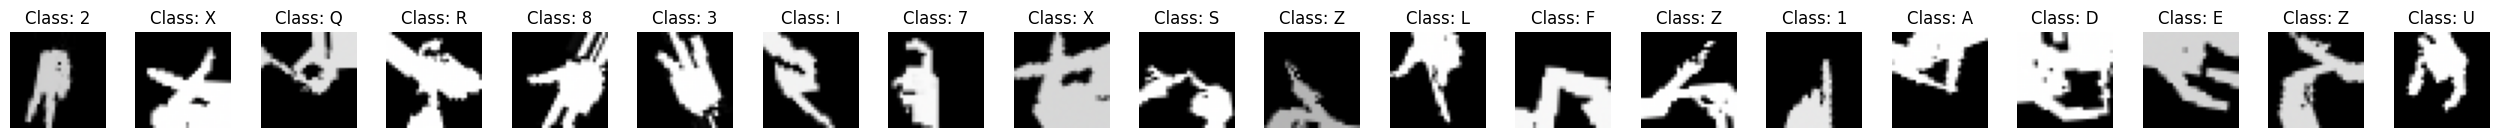

In [ ]:
# Extracting class labels from the training generator
labels = [k for k in train_generator.class_indices]

# Generating a batch of samples from the training generator
sample_generate = train_generator.next()

# Extracting images and titles (labels) from the generated batch
images = sample_generate[0]
titles = sample_generate[1]

# Plotting the images with their corresponding class labels
plt.figure(figsize=(32, 32))

# Looping through the images and titles to create subplots
for i in range(20):
    # Creating a subplot
    plt.subplot(20, 20, i + 1)

    # Adjusting subplot spacing
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Displaying the image
    plt.imshow(images[i])

    # Displaying the class label as the title
    # Note: 'np.argmax' is used to find the index of the maximum value in the one-hot encoded label
    plt.title(f'Class: {labels[np.argmax(titles[i], axis=0)]}')

    # Turning off axis for better visualization
    plt.axis("off")

# Showing the plot
plt.show()


In [ ]:
# Define the input shape
IMAGE_SIZE = [32, 32]

# Load the VGG16 model with specified input shape and excluding top layers
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Print the output shape
print("VGG16 Output Shape:", vgg.output.shape)

VGG16 Output Shape: (None, 1, 1, 512)


In [ ]:
# Loop through each layer in the VGG16 model
for layer in vgg.layers:
    # Set the layer to be non-trainable
    layer.trainable = False


In [ ]:
# Importing the glob module
from glob import glob

# Using glob to get a list of directories matching the specified pattern
folders = glob(r"/content/drive/MyDrive/DS/Final_Dataset_A_Z_SK_NewSign/*")

# Printing the number of directories in the list
print(len(folders))


35


In [ ]:
# Flatten the output of the VGG16 model
x = Flatten()(vgg.output)

# Add a Dense layer with the number of units equal to the number of folders
# Using 'sigmoid' activation for binary classification, adjust accordingly
prediction = Dense(len(folders), activation='sigmoid')(x)

# Create a new model with VGG16 as the base and the added layers
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# Specify the path to save the entire model
model_save_path = '/content/drive/MyDrive/DS/Demodata/VGG16_Dec17.h5'

# Create a ModelCheckpoint callback to save the model during training
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False
)

# Create an EarlyStopping callback to stop training early if the validation loss doesn't improve
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)


In [ ]:
# Function to print a message every 5 minutes
import time
def print_keep_alive():
    while True:
        print("Colab session is active.")
        time.sleep(300)  # Wait for 5 minutes

# Start the keep-alive loop in the background
import threading
keep_alive_thread = threading.Thread(target=print_keep_alive)
keep_alive_thread.daemon = True
keep_alive_thread.start()

Colab session is active.

In [ ]:
#VGG-16 Model Training
history=model.fit(train_generator,
                  steps_per_epoch=len(train_generator),
                  epochs=100,
                  validation_data=validation_generator,
                  validation_steps=len(validation_generator),
                  callbacks=[cp_callback, es_callback]
                 )

Epoch 1/100
1673/1673 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.8405Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.

Epoch 1: saving model to /content/drive/MyDrive/DS/Demodata/VGG16_Dec17.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1673/1673 [==============================] - 8602s 5s/step - loss: 0.6598 - accuracy: 0.8405 - val_loss: 0.4857 - val_accuracy: 0.8825
Epoch 2/100
1673/1673 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.8729Colab session is active.

Epoch 2: saving model to /content/drive/MyDrive/DS/Demodata/VGG16_Dec17.h5
1673/1673 [==============================] - 1188s 710ms/step - loss: 0.5033 - accuracy: 0.8729 - val_loss: 0.3834 - val_accuracy: 0.9067
Epoch 3/100
1673/1673 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.8898Colab session is active.

Epoch 3: saving model to /content/drive/MyDrive/DS/Demodata/VGG16_Dec17.h5
1673/1673 [==============================] - 1228s 734ms/step - loss: 0.4242 - accuracy: 0.8898 - val_loss: 0.3486 - val_accuracy: 0.9165
Epoch 4/100
1673/1673 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.9004Colab session is active.

Epoch 4: saving model to /content/drive/MyDrive/DS/Demodata/VGG16_D

#An example image with the augmentations applied

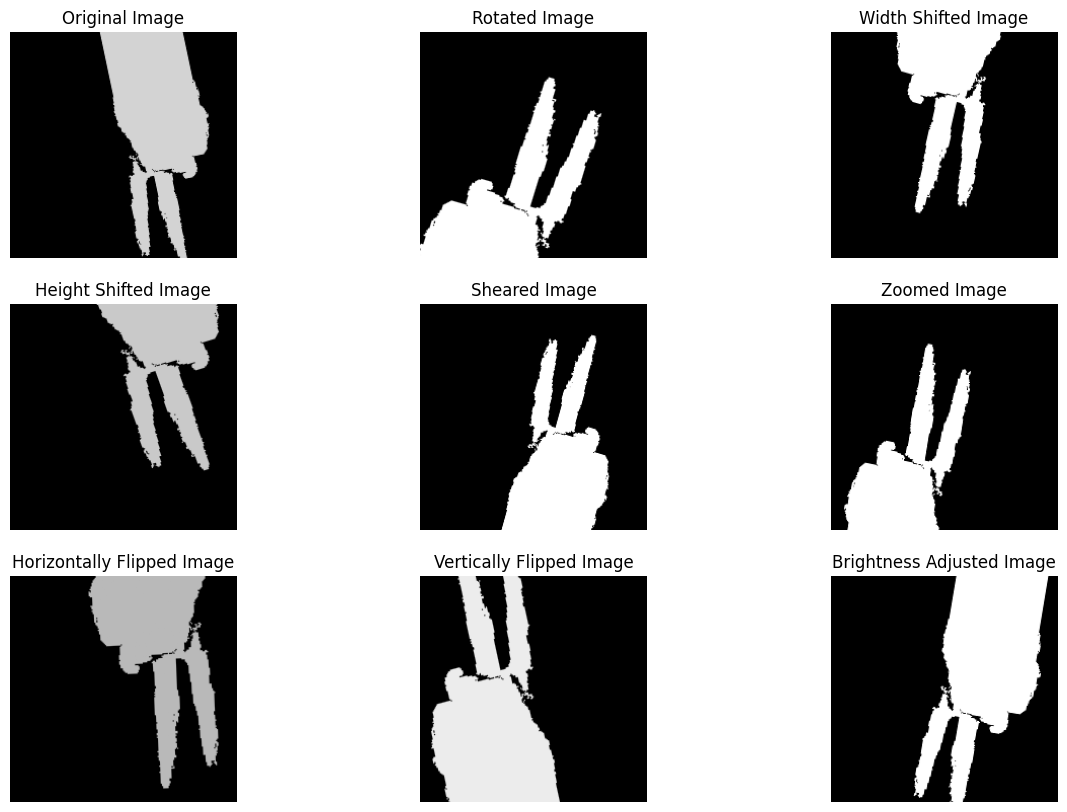

In [3]:
#Import necessary libraries
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Image path
img_path = '/content/drive/MyDrive/DS/Test_NEW_SK_A_Z_1_9/2/012.png'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

# Data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3]
)

# Generate augmented images
augmented_images = []

# Apply each augmentation and store the augmented images
for i in range(9):  # Generate 9 augmented images
    augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
    augmented_images.append(augmented_img)

# Titles for each augmented image
titles = [
    "Original Image",
    "Rotated Image",
    "Width Shifted Image",
    "Height Shifted Image",
    "Sheared Image",
    "Zoomed Image",
    "Horizontally Flipped Image",
    "Vertically Flipped Image",
    "Brightness Adjusted Image"
]

# Display the images
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.show()

# VGG-16 Model Feature Visualization

1/1 [==============================] - 1s 661ms/step


1/1 [==============================] - 1s 883ms/step


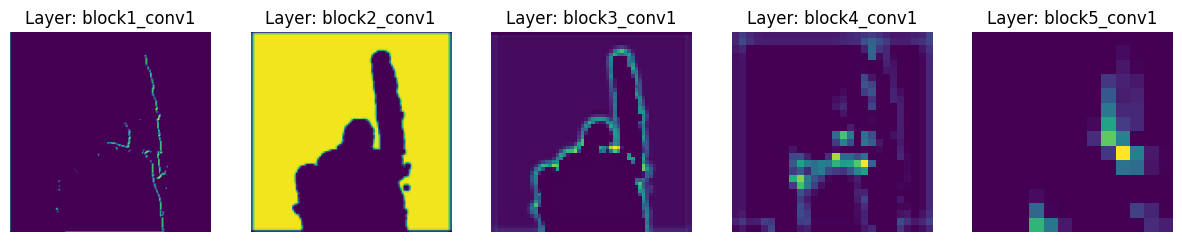

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import backend as K

# Load the pre-trained VGG16 model
model_vgg16 = VGG16(weights='imagenet', include_top=True)

# Choose a convolutional layer from each block to visualize
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Create subplots for each layer
plt.figure(figsize=(15, 6))
for i, layer_name in enumerate(layer_names):
    layer_index = [index for index, layer in enumerate(model_vgg16.layers) if layer.name == layer_name][0]

    # Create a new model that outputs the intermediate layer activations
    activation_model = Model(inputs=model_vgg16.input, outputs=model_vgg16.layers[layer_index].output)

    # Load an example image (replace this with your own image data)
    img_path = '/content/drive/MyDrive/DS/Test_NEW_SK_A_Z_1_9/1/010.png'
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the intermediate layer activations for the example image
    activations = activation_model.predict(img_array)

    # Plot the feature maps for each layer
    plt.subplot(1, 5, i + 1)
    plt.imshow(activations[0, :, :, 0], cmap='viridis')  # Display only the first channel for simplicity
    plt.title(f'Layer: {layer_name}')
    plt.axis('off')

plt.show()
